<a href="https://colab.research.google.com/github/fhac-ewi/recurrent-neural-network/blob/main/%C3%9Cbung_RNN_L%C3%B6sung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Übung 7 - Rekurrente neuronale Netze (RNNs)

## In dieser Übung ...
... beschäftigen wir uns mit rekurrenten neuronalen Netzen, die unter anderem für die Textvorhersage (`text prediction`) eingesetzt werden können. Sie werden ein eigenes Modell zur Vorhersage weiterer Buchstaben (Zeichen) zu einer gegebenen Buchstabensequenz erstellen.

Dazu werden Sie die drei aus der Vorlesung bekannten Varianten von RNNs (Standard, LSTM und GRU) mit Keras implementieren und die Genauigkeit (Accuracy) der Netze miteinander vergleichen.


## 7.0 Vorbereitung

In diesem Abschnitt müssen Sie nichts programmieren! 🎉

Wir haben bereits alle notwendigen Imports für diese Übung hinzugefügt, sodass Sie direkt starten können. Sie müssen lediglich die GPU Unterstützung in Google Colab aktivieren.

**Ihre Aufgaben**

(1) Aktivieren Sie bitte die GPU Unterstützung in Google Colab. Wechseln Sie unter dem Reiter `Laufzeit` -> `Laufzeittyp ändern` von `None` auf `GPU` und bestätigen Sie diese Änderung.

(2) Führen Sie den folgenden Codezelle aus, um die erforderlichen Bibliotheken zu importieren und die GPU Unterstützung zu prüfen. 

  * Hinweis: Wenn Sie dieses Notebook mit dem Direktlink von GitHub geöffnet haben, wird bei der erstmaligen Ausführung eine Warnung angezeigt. Diese müssen Sie durch den Klick auf `Trotzdem ausführen` bestätigen. 

In [27]:
# Import everything needed for this exercise 
import tensorflow as tf
import keras
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from termcolor import colored

print(f"Keras Version: {keras.__version__}; Tensorflow version: {tf.__version__}; NumPy version: {np.__version__}; Python version: ", ".".join(str(x) for x in sys.version_info[:3]))

# Reset random number generators
seed = 1337
np.random.seed(seed)
tf.random.set_seed(seed)

# Check GPU support
from tensorflow.python.client import device_lib
physical_devices = device_lib.list_local_devices()
print("You are using", len(physical_devices), "local devises.", len([x for x in physical_devices if x.device_type == "GPU"]), "are GPUs")
for i, d in enumerate(physical_devices):
    print("  -> Device", i+1, "is a", d.device_type, "=>", d.physical_device_desc if len(d.physical_device_desc) > 0 else d.name)

if len([x for x in physical_devices if x.device_type == "GPU"]) == 0:
  raise Exception("Please enable GPU support before using this notebook. See here: [Runtime] -> [Change runtime type]")    

print("\n🎉🎉🎉 You are ready to go! 🎉🎉🎉")  

# Helper functions
def plot_hist(hist):
    '''
    Plots the accuracy and loss for train and validation over time (epochs).

    Parameters
    hist -- Result from model.fit
    '''
    fig, ax = plt.subplots(1, 1)

    ax.plot(hist.history["loss"], label='loss')
    ax.plot(hist.history["accuracy"], label='accuracy')
    ax.plot(hist.history["val_loss"], label='validation loss')
    ax.plot(hist.history["val_accuracy"], label='validation accuracy')
    ax.set_xlabel("Epoch")
    ax.legend()

    fig.set_size_inches(20, 10)


Keras Version: 2.4.3; Tensorflow version: 2.4.1; NumPy version: 1.19.5; Python version:  3.7.10
You are using 2 local devises. 1 are GPUs
  -> Device 1 is a CPU => /device:CPU:0
  -> Device 2 is a GPU => device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

🎉🎉🎉 You are ready to go! 🎉🎉🎉


## 7.1 One Hot Kodierung

Wir haben in der Vorlesung die One Hot Kodierung (1-aus-n-Code) kennen gelernt. Diese ermöglicht es Zeichen eines Alphabets als Vektoren darzustellen. 

Für ein Alphabet mit `n` einzigartigen Zeichen wird ein Vektor der Länge `n` benötigt. Jedes einzigartige Zeichen wird hierbei als Einheitsvektor definiert. Eine Zeichensequenz mit `m` Zeichen werden als `m` Vektoren mit jeweils der Länge `n` dargestellt.  

**Hinweis** Die vorliegende Implementierung ist für den Umgang mit Zeichen außerhalb des Alphabets konzipiert. Deshalb wird zur Darstellung eines Alphabets mit `n` einzigartigen Zeichen ein Vektor der Länge `n+1` erstellt. Alle Zeichen außerhalb des Alphabets werden durch das `unknown_token` ersetzt. 

Für das Training unseres Netzes werden wir die One Hot Kodierung zur Umwandlung eines Textes in Trainingsdaten nutzen. (Aufgabe 7.2)

* Hinweis: Für weitere Informationen zur One Hot Kodierun schlagen Sie diese in der Vorlesung nach oder benutzen Sie das [Internet](https://www.semanticscholar.org/search?q=one%20hot%20coder&sort=relevance).

In [2]:
class OneHot(object):
    def __init__(self, tokens, unknown_token = "[UNKNOWN]"):
        '''
        Creates a new instance of this class. 

        OneHot can be used to translate categorical data into vectors.

        Parameters
        tokens -- The tokens you want to be able to encode and decode
        unknown_token -- The token to be used when decoding and the net wants to use a not known char
        '''
        self.tokens = tokens
        self.unknown_token = unknown_token
        # Store a bidirectional dictionary containing the characters
        self.char_to_index = dict((token, i + 1) for i, token in enumerate(self.tokens))
        self.index_to_char = dict((i + 1, token) for i, token in enumerate(self.tokens))
        pass

    def encode(self, text_as_tokens, dtype=np.bool_):
        '''
        Encodes a tokenized text into a matrix (each token as vector).

        Parameters:
        text_as_tokens -- List of tokens
        dtype -- (optional) data type like int or bool for optimized performance

        Returns:
        np.array of OneHot encoded tokens (matrix)
        '''
        # Create the encoding matrix
        enc = np.empty((len(text_as_tokens), len(self.tokens) + 1), dtype=dtype)
        for i, token in enumerate(text_as_tokens):
            # Encode every char
            enc[i] = self.encode_token(token=token, dtype=dtype)
        return enc
    
    def encode_token(self, token, dtype=np.bool_):
        '''
        Encodes a single token into a vector.

        Parameters:
        token -- Single token
        dtype -- (optional) data type like int or bool for optimized performance

        Returns:
        np.array of OneHot encoded token (vector)
        '''
        l = len(self.tokens) + 1
        ret = np.zeros((1, l), dtype=dtype)
        if token not in self.char_to_index:
            ret[0, 0] = 1
        else:
            ret[0, self.char_to_index[token]] = 1
        return ret
    
    def decode(self, mat, unknown_token=None):         
        '''
        Decodes a matrix into an array of tokens.

        Parameters:
        mat -- matrix to be decoded. Has to be of shape (len_of_text, vocab_size)
        unknown_token -- Unknown token. If none uses the one from __init__

        Returns:
        array of tokens (chars)
        '''
        return [self.decode_token(mat[x]) for x in range(mat.shape[0])]
    
    def decode_token(self, vec, unknown_token=None):
        '''
        Decodes a vector into a token.

        Parameters:
        vec -- Vector that should be decoded. Has to be on vocab length
        unknown_token -- Unknown token. If none uses the one from __init__

        Returns:
        single token (char)
        '''
        if unknown_token is None:
            unknown_token = self.unknown_token
        if isinstance(vec, tf.Tensor):
            vec = vec.numpy()
        if isinstance(vec, np.ndarray):
            # Use argmax since this will be used in the model created later
            am = np.argmax(vec)
        else:
            am = vec
        if am == 0:
            return unknown_token
        return self.index_to_char[am]

**Ihre Aufgaben**

(1) Untersuchen Sie gegebene Klasse zur One Hot Kodierung und die Funktion der einzelnen Methoden. 

(2) Erstellen Sie für das folgendes Alphabet `HWedlor` eine Instanz der Klasse `OneHot`. 

(3) Kodieren Sie nun die Zeichenfolge `Hello World!` mit der One Hot Kodierung. Wie wird das Zeichen `H` dargestellt? Geben Sie die Dimensionen des Vektors an.

* Hinweis: Sie können zur Umwandlung des Strings in eine Liste von Zeichen die Funktion `tokenize` verwenden. Dies ist aber nicht zwingend erforderlich, da Python den String automatisch als Liste interpretieren kann.

> <Antwort hier einfügen>

> **Musterlösung:** Das Zeichen `H` wird als Vektor `[0 1 0 0 0 0 0 0]` 
dargestellt. Die Dimension ist `1x8`.

(4) Wandeln Sie die kodierte Zeichenfolge zurück in einen für Menschen lesbaren Text. Entspricht der zurückgewandelte Text dem ursprünglichen Input? Falls nicht, beschreiben Sie die Ursache.

* Hinweis: Für eine schönere Ausgabe kann der enkodierte Text mit der Funktion `untokenize` in einen String gewandelt werden.

> <Antwort hier einfügen>

> **Musterlösung:** Der ursprüngliche Text und der kodierte und dekodierte Text ist nicht mehr identisch, da zwei Zeichen (Leerzeichen, Ausrufezeichen) nicht im Alphabet vorhanden sind. Durch Hinzufügen dieser Zeichen ins Alphabet würde man den ursprünglichen Text erhalten.

In [3]:
def tokenize(text):
    '''
    Converts the given text (string) in a list of chars.
    '''
    return list(text)

def untokenize(tokens):
    '''
    Converts the given tokens (list of chars) in a string.
    '''
    return "".join(tokens)

tokens = 'HWedlor'

# code here
one_hot = OneHot(tokens=tokens)

text='Hello World!'

coded_text = one_hot.encode(text)
print("Shape of coded text: ", coded_text.shape)
print("H coded (first letter in coded text): ", coded_text[0].astype(int))

encoded_text = one_hot.decode(coded_text)

print(untokenize(encoded_text))

Shape of coded text:  (12, 8)
H coded (first letter in coded text):  [0 1 0 0 0 0 0 0]
Hello[UNKNOWN]World[UNKNOWN]


## 7.2 Datensatz vorbereiten

In dieser Übung verwenden wir das Buch Shakespeare als Datensatz. Ziel des Modells soll die Vorhersage weiterer Zeichen zu einer gegebenen Zeichensequenz sein.

Sie können aus einem Buch (sehr lange Zeichensequenz) Trainingsdaten erzeugen, indem Sie jedem Zeichen das jeweils nächste Zeichen als Label zuweisen. Die folgende Grafik veranschaulicht dieses Verfahren:
![Image](https://raw.githubusercontent.com/fhac-ewi/recurrent-neural-network/main/TrainData.png)

In diesem Aufgabenteil wird das Buch einlegesen, mithilfe der One Hot Kodierung (Aufgabe 7.1) in Vektoren umgewandelt, in Teilsequenzen aufgeteilt und als Trainingsdaten und Validierungsdaten aufgeteilt.

* Hinweis: Sie können theoretisch jeden beliebigen Text als Datensatz für das Training des Modells verwenden. (z.B. Harry Potter Bücher, Coronaschutzverordnungen, Nachrichtenartikel, ...)

**Ihre Aufgaben**

(1) Führen Sie die folgende Codezelle aus, um das Buch Shakespeare TODO einzulesen. Untersuchen Sie den Datensatz, indem Sie einen kurzen Auszug des Textes ausgeben.

(2) Erstellen Sie aus dem Text das Alphabet (`tokens`) und geben die Länge aus. Das Alphabet soll alle Zeichen des Textes enthalten.

* Hinweis: Sie können den `text` mit der Funktion `tokenize` in eine Liste umwandeln. Dieser kann dann zu einem [Set](https://docs.python.org/3/tutorial/datastructures.html#sets) gewandelt werden.

(3) Erstellen Sie für das Alphabet eine One Hot Kodierung und wenden diese auf den `text` an. Nutzen Sie dazu Ihre die Erkentnisse aus Aufgabe 7.1.

(4) Teilen Sie den kodierten Text in Sequenzen auf. Wie würden Sie die Länge der einzelnen Sequenzen wählen? 
Verwenden Sie dazu die Funktion vorgegebene Funktion `sequenze_split`.

* Erklärung: Wieso wird der Text in Sequenzen gesplittet?
</br>Durch die Splittung des Textes in mehrere Sequenzen wird TODO.

* Hinweis: Die Sequenzen sollten lang genug sein, dass das RNN Zusammenhänge in einem Satz (und ggf. darüber hinaus) erlenen kann. Die Sequenzlänge sollte jedoch kurz genug sein, damit eine ausreichende Anzahl an Zeichen für das Training vorhanden ist.
<br>Die von uns verwendete Sequenzlänge haben wir mit [Rot13](https://rot13.de/) kodiert: `Rvauhaqreg`

(5) Erstellen Sie nun aus den sequenzierten Daten das Feature `X` und das Label `y`. Für die Vorhersage von einzelnen Zeichen ist jeweils das nächste Zeichen das Label des vorherigen Zeichens. Das Label `y` wird deshalb aus den gleichen Werte des Features `X` gebildet, ist jedoch um +1 verschoben. 


* Beispiel: Die Sequenz `Hello World!` kann in **X** `Hello World` mit dem zugehörigen Label **y** `ello World!` aufgeteilt werden.
* Hinweis: Untersuchen Sie die Rückgabe der Funktion `sequenze_split`. In welcher der drei Komponenten müssen Sie die Verschiebung vornehmen?

(6) Konvertieren Sie nun die Daten in ein Trainings- und Validierungsset. Nutzen Sie dafür die Funktion `train_test_split` (Eine Dokumentation finden Sie [hier](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)). 

In [4]:
# maximum text length 
# 1. Protection against "OutOfMemory" (poor RAM 😥)
# 2. Adjustment for making training faster (but you will gain less accuracy)
MAX_TEXT_LEN = 1_200_000 

path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

text = open(path_to_file, 'rb').read().decode(encoding='utf-8') # .lower() für schnelleres Training anfügen
print(f'Length of text: {len(text)} characters')
if len(text) > MAX_TEXT_LEN:
    print("Text is too long. Cutting it to", MAX_TEXT_LEN, f"characters. That is {100 * MAX_TEXT_LEN / len(text):6.2f} %")
    text = text[:MAX_TEXT_LEN]

# helper function for 7.2.4
def sequenze_split(coded_text, sequence_len):
    """
    Splits a given coded text (text converted with OneHot) into multiple subsequenzes
    """
    target_shape = (int(coded_text.shape[0] / (sequence_len + 1)) , (sequence_len + 1) , coded_text.shape[1])
    coded_text_seq = np.empty(target_shape, dtype=coded_text.dtype)
    for s in range(coded_text_seq.shape[0]):
        coded_text_seq[s] = coded_text[s * (sequence_len + 1):(s + 1) * (sequence_len + 1)]

    # returns 3D matrix (sequences, letters per sequence, letter as one hot coded vector)    
    return coded_text_seq    

# code here   
# Aufgabe 7.2.1 
print("Segment of text:")
print("-" * 60)
print(colored(text[:250], 'blue')) 
print("-" * 60)

# Aufgabe 7.2.2 - Alphabet erstellen
tokens = sorted(set(text))
print("Length of raw text:", len(text))
print("Numbers of tokens (unique letters): ", len(tokens))


# Aufgabe 7.2.3 - One Hot
one_hot = OneHot(tokens=tokens)
coded_text = one_hot.encode(text)
print("Shape of coded text: ", coded_text.shape)

# Aufgabe 7.2.4 - Aufteilung in Sequenzen
sequence_len = 100
coded_text_seq = sequenze_split(coded_text, sequence_len)
print("Shape of coded text split into sequences", coded_text_seq.shape)

# Aufgabe 7.2.5
X = coded_text_seq[:, :-1]
y = coded_text_seq[:, 1:]

# Aufgabe 7.2.6
validation_size = 1/6

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_size)

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_val  :", X_val.shape, X_val.dtype)
print("y_val  :", y_val.shape, y_val.dtype)

print("-" * 40)
print(colored(untokenize(one_hot.decode(X_train[0])), 'blue'))
print("-" * 40)
print(colored(untokenize(one_hot.decode(y_train[0])), 'green'))
print("-" * 40)    

Length of text: 1115394 characters
Segment of text:
------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

------------------------------------------------------------
Length of raw text: 1115394
Numbers of tokens (unique letters):  65
Shape of coded text:  (1115394, 66)
Shape of coded text split into sequences (11043, 101, 66)
X_train: (9202, 100, 66) bool
y_train: (9202, 100, 66) bool
X_val  : (1841, 100, 66) bool
y_val  : (1841, 100, 66) bool
----------------------------------------
vereign's face.
I am the last of noble Edward's sons,
Of whom thy father, Prince of Wales, was first
----------------------------------------
ereign's face.
I am the last of noble Edward's sons,
Of whom thy father, Prince of Wales, was first:
---------

🎉🎉🎉 **Geschafft!** 🎉🎉🎉

Sie haben nun aus einem Buch Trainingsdaten für ein RNN zur Vorhersage von Zeichen erstellt! 
- Text einlesen
- Text in Tokens umwandeln
- Alphabet festlegen
- One Hot Kodierung erstellen und anwenden
- In Sequenzen aufteilen
- `X` und `y` festlegen
- Aufteilung in Training und Validierungsset

... jetzt können Sie mit dem eigentlichen Modell fortfahren.

## 7.3 RNN Modell erstellen
In diesem Aufgabenteil ein [SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/) (auch als Vanilla bezeichnet) zur Vorhersage des weiteren Verlaufs einer Zeichensequenz erstellt werden.

Dafür nutzen Sie ein Sequential Model von Keras mit einer SimpleRNN Layer und einer Dense Layer mit Softmax. 
TOOD Schöner beschreiben
- Many to Many Netz. Ggf Bildchen einfügen?

**Ihre Aufgaben**

(1) Bestimmen Sie nun die Parameter, die für das Modell benötigt werden:
- Shape der Eingabe/des Trainingdatensatzes. (Anzahl Zeichen, Länge eines vektorisierten Zeichens)
- Länge des Alphabets (inklusive des `unknown_tokens`). Also die Anzahl der Tokens, die das Modell vorhersagen können soll.
  

(2) Erstellen Sie das entsprechende [Sequential](https://keras.io/api/models/sequential/) Modell und fügen folgende Schichten hinzu:
TODO Anpassen, wenn alles geregelt ist.
- [SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/) mit 128 Units als Output Space (= Größe des Hidden State), der Shape der Eingabe und dem Parameter `return_sequences=true`. 
- [Dense](https://keras.io/api/layers/core_layers/dense/) mit der Anzahl der Tokens und der Aktivierungsfunktion `softmax`.

Kompilieren Sie anschließend das Modell mit der `categorical_crossentropy` Loss Function, dem [RMSprop](https://keras.io/api/optimizers/rmsprop/) Optimizer mit einer `learning_rate` von 0.01 und fügen als Metrics die `accuracy` hinzu.

In [5]:
# code here
# Aufgabe 7.3.1
# Length of the vocabulary in chars
vocab_size = X_train.shape[-1]
print("Numbers of unique tokens: ", vocab_size)

# The input shape
input_shape = X_train.shape[1:]
print("Input shape: ", input_shape)

# Number of RNN units
rnn_units = 128

# Aufgabe 7.3.2 - SimpleRNN
# model = ....
model = tf.keras.Sequential(name="SimpleRNN_Model")
model.add(tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, input_shape=input_shape, name="The_Brain"))
model.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="The_Hand"))
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Numbers of unique tokens:  66
Input shape:  (100, 66)
Model: "SimpleRNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
The_Brain (SimpleRNN)        (None, 100, 128)          24960     
_________________________________________________________________
The_Hand (Dense)             (None, 100, 66)           8514      
Total params: 33,474
Trainable params: 33,474
Non-trainable params: 0
_________________________________________________________________


## 7.4 RNN Modell trainieren
In diesem Aufgabenteil soll das Modell trainiert werden und der Loss und die Accuracy untersucht werden.

**Ihre Aufgaben**

(1) Wenden Sie die Methode [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) auf Ihr Modell an. Geben Sie als Parameter neben den Trainingsdaten auch die Anzahl der Epochen, die Batchsize und die zuvor erstellten Validierungsdaten (Aufgabe 7.2.6) an. Speichern Sie das Ergebnis des Trainings für eine spätere Analyse in einer Variable!

Im Code sind bereits Startwerte für das Training vorgegeben. Sie können diese nach Belieben anpassen. 

**Eine Accuracy von 50% ist für diesen Schritt völlig ausreichend!**

* Hinweis: **Die Trainingsdauer sollte zwischen 1 und 3 Minuten liegen!** 
</br>Nach den ersten drei Epochen sollte die Genauigkeit bereits über 30% liegen. Falls nicht, prüfen Sie noch einmal die vorherigen Aufgabenteile oder fragen Sie Team RNN um Hilfe!

* Tipp: Falls Sie das Gefühl haben, dass Ihr Modell noch einen Fehler enthalten könnte, fügen Sie in Aufgabe 7.2 im Codeblock Zeile 8 ein `.lower()` ein. Dadurch wird der Datensatz in Kleinbuchstaben umgewandelt und die Größe des Alphabets verringert. 

In [6]:
EPOCHS = 20
BATCH_SIZE = 128

t1 = time.time()
# code here
hist = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(X_val, y_val))
t2 = time.time()

print("Training took: ", timedelta(seconds=t2-t1))

Epoch 1/20
72/72 [==============================] - 8s 96ms/step - loss: 3.5277 - accuracy: 0.1467 - val_loss: 2.5184 - val_accuracy: 0.3007
Epoch 2/20
72/72 [==============================] - 6s 85ms/step - loss: 2.3950 - accuracy: 0.3248 - val_loss: 2.2564 - val_accuracy: 0.3515
Epoch 3/20
72/72 [==============================] - 6s 85ms/step - loss: 2.1566 - accuracy: 0.3798 - val_loss: 2.0401 - val_accuracy: 0.4157
Epoch 4/20
72/72 [==============================] - 6s 85ms/step - loss: 2.0116 - accuracy: 0.4157 - val_loss: 1.9571 - val_accuracy: 0.4295
Epoch 5/20
72/72 [==============================] - 6s 86ms/step - loss: 1.9298 - accuracy: 0.4381 - val_loss: 1.9026 - val_accuracy: 0.4384
Epoch 6/20
72/72 [==============================] - 6s 87ms/step - loss: 1.8702 - accuracy: 0.4524 - val_loss: 1.8475 - val_accuracy: 0.4575
Epoch 7/20
72/72 [==============================] - 6s 87ms/step - loss: 1.8292 - accuracy: 0.4646 - val_loss: 1.8076 - val_accuracy: 0.4733
Epoch 8/20
72

(2) Plotten Sie Accuracy und Loss über die Epochen. Bewerten Sie den Verlauf des Trainings. Wie könnte das Training verbessert werden?

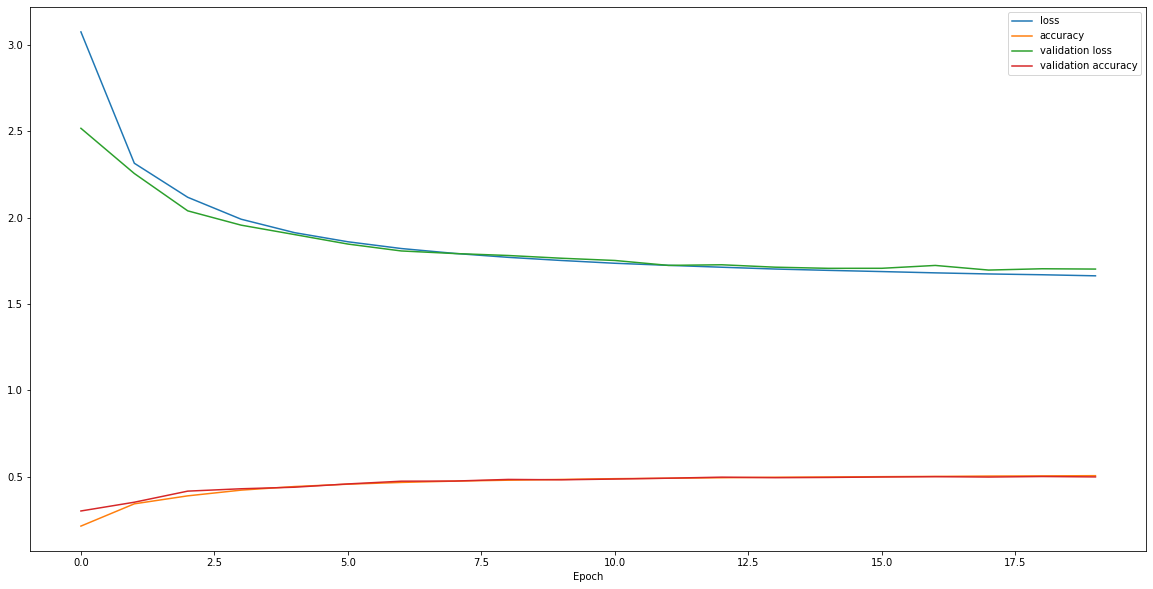

In [7]:
fig, ax = plt.subplots(1, 1)

ax.plot(hist.history["loss"], label='loss')
ax.plot(hist.history["accuracy"], label='accuracy')
ax.plot(hist.history["val_loss"], label='validation loss')
ax.plot(hist.history["val_accuracy"], label='validation accuracy')
ax.set_xlabel("Epoch")
ax.legend()

fig.set_size_inches(20, 10)

plt.show()

## 7.5 Vorhersagen treffen
Das zuvor trainierte Modell soll nun für die Vorhersage von Buchstaben genutzt werden. TODO Anpassen

**Ihre Aufgaben**

(1) Vervollständigen Sie die Methode `predict`. Kodieren Sie dafür den Text mit der One Hot Kodierung, führen die Vorhersage mit dem trainierten Modell durch und geben das letzte dekodierte Zeichen der Vorhersage zurück.  

Testen Sie die Methode mit einzelnen Wörtern. Geben Sie dafür den ersten Teil des Wortes in die Predict Methode hinein und überprüfen die Rückgabe. Sie können auch kürzere Sätze hineingeben und die Ausgabe prüfen.

* Beispiel: Bei `Prince` wird der Input als `Princ` gewählt und das erwartete Ergebnis lautet `e`.

In [8]:
def predict(text, one_hot, trainied_model):
    '''
    Wandelt den Text mithilfe der OneHot Kodierung in eine Input um, 
    führt mithilfe des trainierten Modells eine prediction durch 
    und gibt das vorhergesagte Zeichen als Text aus.
    '''
    # coce here
    encoded_text = one_hot.encode(tokenize(text))
    prediction = trainied_model.predict(encoded_text.reshape((1, *encoded_text.shape)))
    return untokenize(one_hot.decode(prediction[0]))[-1]

print("Prediction of 'fathe' is:", predict("fathe", one_hot, model))   
print("Prediction of 'Princ' is:", predict("Princ", one_hot, model))  

Prediction of 'fathe' is: r
Prediction of 'Princ' is: e


(2) **Optional** **Wettkampf** Erweitern Sie die `predict()` Methode aus dem vorherigen Aufgabenteil (7.5.1) in eine Methode um, die 100 weitere Zeichen vorhersagt und so womöglich einen ganzen Satz vervollständigt. 

In [9]:
# code here
def predict_sentence(text, prediction_length, one_hot, trainied_model):
    '''
    Führt mehrere Predictions Iterativ durch.
    '''
    # code here
    for x in range(prediction_length):
        text += predict(text, one_hot, trainied_model)
    return text

print(predict_sentence("ROMEO:\n", 100, one_hot, model))      

ROMEO:
Her see the blood to the blood to the blood to the blood to the blood to the blood to the blood to t


(3) **Optional** Nutzen Sie zum Beispiel [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#Using-Interact) um Texte live eingeben zu können und Vorhersagen zu erhalten. Testen Sie das trainierte Modell und Ihre `predict` Methode (Aufgabenteil 7.5.1).


In [10]:
import ipywidgets as widgets
from IPython.display import display

In [11]:
# code here
def verbose_prediction(text, one_hot, trainied_model):
    if len(text) == 0:
        text = " "
    prediction = predict(text=text, one_hot=one_hot, trainied_model=trainied_model)
    print(f"I think the next will be \"{prediction}\" after you said \"{text}\"")

w = widgets.interactive(verbose_prediction,
                        text=widgets.Text(value='ROME', placeholder='Type something', description='Your text:', disabled=False),
                        one_hot=widgets.fixed(one_hot),
                        trainied_model=widgets.fixed(model),
                       )

verbose_prediction("Edwar", one_hot=one_hot, trainied_model=model)

display(w)

I think the next will be "d" after you said "Edwar"


interactive(children=(Text(value='ROME', description='Your text:', placeholder='Type something'), Output()), _…

## 7.6 **Optional** RNN Varianten LSTM und GRU

Neben SimpleRNN wurden in der Vorlesung zwei weitere Varianten von RNNs vorgestellt, die mit dem Vanishing Gradient Problem deutlich besser als das SimpleRNN umgehen können.

In dieser Aufgabe sollen diese beiden Varianten trainiert werden und die Lernkurve und getroffenen Vorhersagen untersucht werden.

**Ihre Aufgaben**

(1) Trainieren Sie auf dem gleichen Datensatz zwei Modelle der Varianten LSTM und GRU. Verwenden Sie Ihr Modell aus Aufgabe 7.3 und ersetzen Sie die SimpleRNN Layer durch eine passende [Layer von Keras](https://keras.io/api/layers/recurrent_layers/).

**Speichern Sie die Modelle in neuen Variablen ab!**


In [12]:
# code here
# model_lstm = ....
model_lstm = tf.keras.Sequential(name="LSTM_Model")
model_lstm.add(tf.keras.layers.LSTM(rnn_units, return_sequences=True, input_shape=input_shape, name="The_Brain"))
model_lstm.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="The_Hand"))
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_lstm.summary()

# model_gru = ....
model_gru = tf.keras.Sequential(name="GRU_Model")
model_gru.add(tf.keras.layers.LSTM(rnn_units, return_sequences=True, input_shape=input_shape, name="The_Brain"))
model_gru.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="The_Hand"))
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_gru.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_gru.summary()


Model: "LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
The_Brain (LSTM)             (None, 100, 128)          99840     
_________________________________________________________________
The_Hand (Dense)             (None, 100, 66)           8514      
Total params: 108,354
Trainable params: 108,354
Non-trainable params: 0
_________________________________________________________________
Model: "GRU_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
The_Brain (LSTM)             (None, 100, 128)          99840     
_________________________________________________________________
The_Hand (Dense)             (None, 100, 66)           8514      
Total params: 108,354
Trainable params: 108,354
Non-trainable params: 0
_________________________________________________________________


In [13]:
t1 = time.time()
# code here (train lstm)
hist_lstm = model_lstm.fit(X_train, y_train,
                           batch_size=BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=(X_val, y_val))
t2 = time.time()
t_lstm = t2 - t1

t1 = time.time()
# code here (train gru)
hist_gru = model_gru.fit(X_train, y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val))
t2 = time.time()
t_gru = t2 - t1

print("LSTM Training took:", timedelta(seconds=t_lstm))
print("GRU  Training took:", timedelta(seconds=t_gru))

Epoch 1/20
72/72 [==============================] - 5s 39ms/step - loss: 3.2796 - accuracy: 0.1690 - val_loss: 2.4746 - val_accuracy: 0.3046
Epoch 2/20
72/72 [==============================] - 2s 30ms/step - loss: 2.2992 - accuracy: 0.3417 - val_loss: 2.0567 - val_accuracy: 0.4035
Epoch 3/20
72/72 [==============================] - 2s 30ms/step - loss: 2.0011 - accuracy: 0.4146 - val_loss: 1.8661 - val_accuracy: 0.4491
Epoch 4/20
72/72 [==============================] - 2s 30ms/step - loss: 1.8285 - accuracy: 0.4589 - val_loss: 1.7425 - val_accuracy: 0.4814
Epoch 5/20
72/72 [==============================] - 2s 30ms/step - loss: 1.7179 - accuracy: 0.4886 - val_loss: 1.6725 - val_accuracy: 0.5010
Epoch 6/20
72/72 [==============================] - 2s 31ms/step - loss: 1.6376 - accuracy: 0.5097 - val_loss: 1.6180 - val_accuracy: 0.5169
Epoch 7/20
72/72 [==============================] - 2s 31ms/step - loss: 1.5864 - accuracy: 0.5230 - val_loss: 1.5808 - val_accuracy: 0.5253
Epoch 8/20
72

(2) Plotten Sie die Accuracy und Loss der drei Modelle in einem Diagramm. Verwenden Sie zusätzlich die Methode `predict_sentence` (7.5.2), um die Vorhersagen zu vergleichen.
Welche Erkenntnisse haben Sie aus dem Training gezogen? Wie könnten die Vorhersagen verbessert werden? 

> <Antwort hier einfügen>

> **Musterlösung:**
<br>Erkenntnisse:
- SimpleRNN leidet unter Gedächtnisverlust
- LSTM und GRU haben eine geringfügig bessere Accuracy - die vorhergesagten Texte sind aber **deutlich** besser!
<br>Verbesserung:
- Mehr Trainingszeit Zeit
- Längere Sequenzen an Testdaten


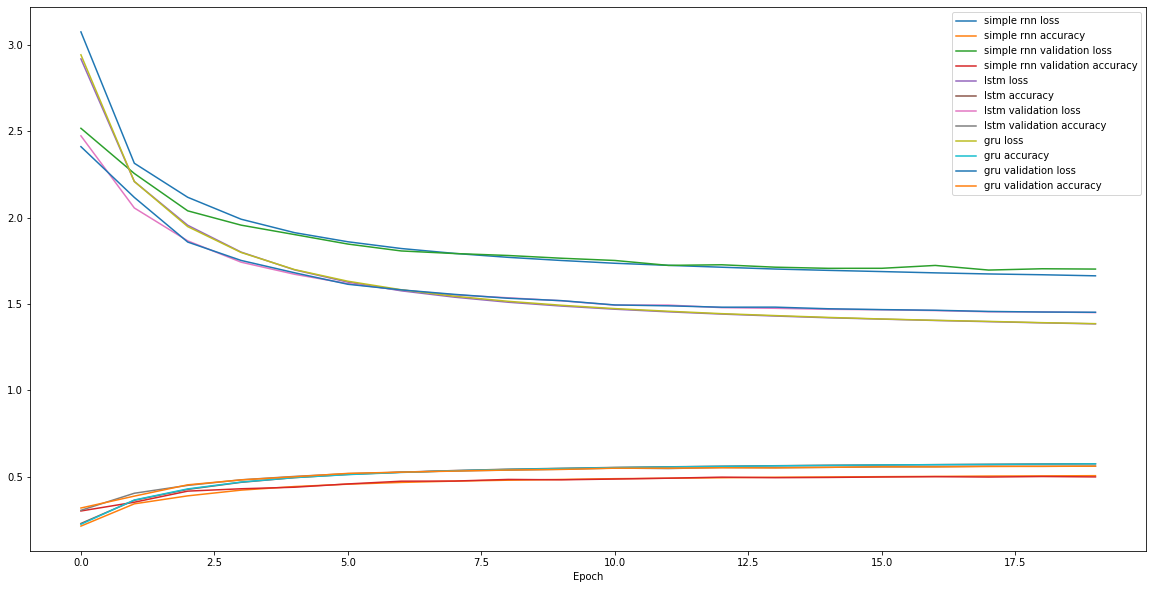

In [23]:
# code here
fig, ax = plt.subplots(1, 1)

for n, h in [("simple rnn", hist), ("lstm", hist_lstm), ("gru", hist_gru)]:

    ax.plot(h.history["loss"], label=f'{n} loss')
    ax.plot(h.history["accuracy"], label=f'{n} accuracy')
    ax.plot(h.history["val_loss"], label=f'{n} validation loss')
    ax.plot(h.history["val_accuracy"], label=f'{n} validation accuracy')

ax.set_xlabel("Epoch")
ax.legend()

fig.set_size_inches(20, 10)

plt.show()

In [14]:
# Compare Output

print("-"*15, "%9s" % "SimpleRNN", "-"*15, "\n")
print(predict_sentence("ROMEO:\n", 200, one_hot, model)) 
print("-"*15, "%9s" % "LSTM", "-"*15, "\n")
print(predict_sentence("ROMEO:\n", 200, one_hot, model_lstm)) 
print("-"*15, "%9s" % "GRU", "-"*15, "\n")
print(predict_sentence("ROMEO:\n", 200, one_hot, model_gru)) 

--------------- SimpleRNN --------------- 

ROMEO:
Her see the blood to the blood to the blood to the blood to the blood to the blood to the blood to the blood to the blood to the blood to the blood to the blood to the blood to the blood to the blood 
---------------      LSTM --------------- 

ROMEO:
Then is the brother that I will not so may be so for the commons of the court.

PETRUCHIO:
I will not so much as the best the state,
And the state the court of the court of the court.

PETRUCHIO:
I wi
---------------       GRU --------------- 

ROMEO:
What shall be so shall be so fair state that thou art thou didst not stay.

KING EDWARD IV:
What shall be so shall be so fair state that thou art thou didst not stay.

KING EDWARD IV:
What shall be so


## 7.7 **Optional** Schriftsteller

Mit den Erkenntnissen aus der Vorlesung, den vorherigen Übungsaufgaben und ein bisschen Python Erfahrung sind Sie nun in der Lage nicht nur einzele Buchstaben vorherzusagen, sondern könnten auch beliebig viele Zeichen generieren und dadurch ganze Bücher schreiben [lassen].

Sie können für diesen Aufgabenteil den ursprünglichen Datensatz anpassen und Beispielsweise die Coronaschutzverordnung, wissenschaftliche Artikel oder Meldungen aus Tageszeitungen verwenden.

Gelingt es Ihnen den 8ten Band von Harry Potter zu erstellen?

**Ihre Aufgaben**

(1) Was müssten Sie ändern, um mithilfe des bisherigen Modells ein ganzes Buch erstellen zu lassen? Glauben Sie, dass das Ergebnis lesbar wäre?

> <Antwort hier einfügen>

> **Musterlösung:** TODO
Sowas wie
- Mehr Trainingszeit
- Hierfür wollen wir wenn möglich beliebig viele Zeichen generieren, dabei den hidden state behalten und nicht konstant das bisher geschriebene als Input wieder einfügen. Deshalb nutzen wir hier eine eigene Klasse für das Netz, die dann die Layer enthält, aber aich den Hidden state zurück geben kann.

(2) Erstellen Sie ein neues Modell, welches zu einem gegebenen Text von wenigen Worten in der Lage ist ein ganzes Buch zu vervollständigen.

In [16]:
class CustomRNNModel(tf.keras.Model):
    def __init__(self, vocab_size, rnn_units, rnn_layer_type = tf.keras.layers.GRU):
        super().__init__(self)
        # Put layers here. We will call them manually but store them here
        self.rnn_layer = rnn_layer_type(rnn_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, states=None, return_state=False, training=False):
        # Here we put our input through all out layers
        x = tf.cast(inputs, dtype=float)
        if states is None:
            # Get an initial kind of empty state
            states = self.rnn_layer.get_initial_state(x)
        
        x, states = self.rnn_layer(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [17]:
literatur_model = CustomRNNModel(vocab_size=vocab_size, rnn_units=rnn_units)

input_example_batch = X_train[0]
input_example_batch = input_example_batch.reshape((1, *input_example_batch.shape))

example_batch_predictions = literatur_model.predict(input_example_batch)
print(input_example_batch.shape, y_train[0].shape, example_batch_predictions.shape)

print("Test sequence:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(X_train[0])), "\n", "-"*25)
print("Expected result:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(y_train[0])), "\n", "-"*25)
print("Untrained prediction:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(example_batch_predictions[0])), "\n", "-"*25)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
literatur_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

literatur_model.summary()

(1, 100, 66) (100, 66) (1, 100, 66)
Test sequence: 
 ------------------------- 
 vereign's face.
I am the last of noble Edward's sons,
Of whom thy father, Prince of Wales, was first 
 -------------------------
Expected result: 
 ------------------------- 
 ereign's face.
I am the last of noble Edward's sons,
Of whom thy father, Prince of Wales, was first: 
 -------------------------
Untrained prediction: 
 ------------------------- 
 e---3I$N'i&tR--[UNKNOWN]iitkgRz-zGSCRRs;:gsR[UNKNOWN]--Iggg-RRCgCsCCR.J&:gbUJgRzMz&tRt--RiIx3$R--[UNKNOWN];:$tA--.ggtCg&3x-R 
 -------------------------
Model: "custom_rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    multiple                  75264     
_________________________________________________________________
dense (Dense)                multiple                  8514      
Total params: 83,778
Trainable params: 83,778
Non-tra

In [18]:
t1 = time.time()
hist_custom = literatur_model.fit(X_train, y_train,
                           batch_size=BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=(X_val, y_val))
t2 = time.time()

print("Training took:", timedelta(seconds=t2-t1))

Epoch 1/20
72/72 [==============================] - 20s 255ms/step - loss: 2.9631 - accuracy: 0.2468 - val_loss: 2.0917 - val_accuracy: 0.3894
Epoch 2/20
72/72 [==============================] - 18s 250ms/step - loss: 2.0169 - accuracy: 0.4112 - val_loss: 1.8416 - val_accuracy: 0.4603
Epoch 3/20
72/72 [==============================] - 18s 246ms/step - loss: 1.7953 - accuracy: 0.4678 - val_loss: 1.7112 - val_accuracy: 0.4882
Epoch 4/20
72/72 [==============================] - 18s 246ms/step - loss: 1.6842 - accuracy: 0.4966 - val_loss: 1.6355 - val_accuracy: 0.5099
Epoch 5/20
72/72 [==============================] - 18s 243ms/step - loss: 1.6156 - accuracy: 0.5148 - val_loss: 1.5965 - val_accuracy: 0.5219
Epoch 6/20
72/72 [==============================] - 17s 238ms/step - loss: 1.5676 - accuracy: 0.5266 - val_loss: 1.5677 - val_accuracy: 0.5298
Epoch 7/20
72/72 [==============================] - 18s 249ms/step - loss: 1.5400 - accuracy: 0.5338 - val_loss: 1.5491 - val_accuracy: 0.5312

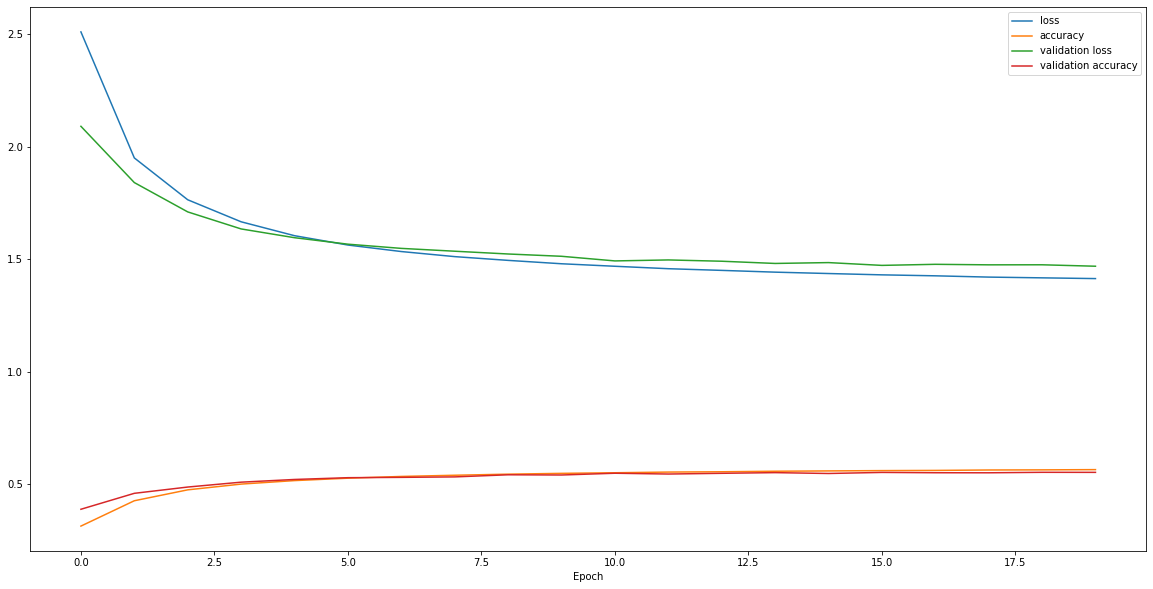

In [19]:
fig, ax = plt.subplots(1, 1)

ax.plot(hist_custom.history["loss"], label='loss')
ax.plot(hist_custom.history["accuracy"], label='accuracy')
ax.plot(hist_custom.history["val_loss"], label='validation loss')
ax.plot(hist_custom.history["val_accuracy"], label='validation accuracy')
ax.set_xlabel("Epoch")
ax.legend()

fig.set_size_inches(20, 10)

plt.show()

In [20]:
def create_text(amount_symbols, init_text, text_model):    
    # Tokenize text
    ret = tokenize(init_text)
    
    states = None
    current_char = one_hot.encode(ret, dtype=float)
    # For some reason we have to add one dimension
    current_char = current_char.reshape(1, *current_char.shape)
    
    for i in range(amount_symbols):
        current_char, states = text_model(current_char, return_state = True, states = states)
        # Only add last char if several got 
        ret.append(one_hot.decode(current_char[0])[-1])
        
    return untokenize(ret)
    

In [21]:
created_text = create_text(250, "ROMEO:\n", literatur_model)

print(created_text)


print("-"*15, "%9s" % "CustomRNN", "-"*15, "\n")
print(predict_sentence("ROMEO:\n", 200, one_hot, literatur_model)) 

ROMEO:
Tote is 
ieeseserenenenererenenen s n s  sas n 
SR:
I:
TO:
AANRU:
SN:
AI:
I:
SA:
BWA:
L:
SINALENot:
RAM
I:
K: GB:
IAN:
S:
TA:
TIR

 :

AINALA:
TEY
K:
TENASBor wel:
wDA
BA:
SNENor os s s t ne
an n  es s a seis ss

is s s 
  ls   s s se ss 
 is s ain n
--------------- CustomRNN --------------- 

ROMEO:
The sun of the subjects to the subjects,
And that shall be so some command that shall be so some son as I will be so some son as I will be so some son as I will be so some son as I will be so some son
